In [151]:
#Импорт всех необходимых библиотек
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pickle
from sklearn.model_selection import KFold
from scipy.stats import norm
from scipy import stats
import xgboost as xgb
import catboost
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import seaborn as sns
%matplotlib inline
import numpy as np
import warnings
import copy
warnings.filterwarnings('ignore')
import re
import ast

In [152]:
data = pd.read_csv('data.csv')
top = ['WA', 'NH', 'MN', 'UT', 'VT', 'MD', 'VA', 'MA', 'NE', 'CO', 'WI', 'NJ', 'FL', 'IA', 'ND', 'ID']
mid = ['GA', 'NC', 'CA', 'SD', 'CT', 'KS', 'DE', 'HI', 'NY', 'RI', 'OR', 'MO', 'MT', 'TN', 'WY', 'ME']
    
data = data.drop(['MlsId', 'mls-id', 'private pool'],axis = 1)
def state(x):
    if x in top:
        return 2
    if x in mid:
        return 1
    return 0
    
def func_cool(x):
    if x == '':
        return 0
    return 1

def func_pool(x):
    if type(x) != int:
        x = x.replace(x, '1')
    return int(x)
    
def func_stor(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if (len(x) > 1):
            x = x[0]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return 1
    return x
    
def func_cost(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if len(x) > 2:
            x = x[0] + x[1] + x[2]
        elif len(x) > 1:
            x = x[0] + x[1]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return np.nan
    return int(x)
    
def func_area(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if len(x) > 1:
            x = x[0] + x[1]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return np.nan
    return int(x)

def func_lot(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if len(x) > 1:
            x = x[0] + x[1]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return np.nan
    return int(x)
    
def func_built(x):
    x = re.findall(r'\d+',x)
    if len(x) > 1:
        x = x[0] + x[1]
    elif len(x) == 1:
        x = x[0]
    if not x:
        return np.nan
    return int(x)
        
def data_func1(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][0].get('factValue')

def data_func2(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][1].get('factValue')

def data_func3(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][2].get('factValue')

def data_func4(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][3].get('factValue')

def data_func5(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][4].get('factValue')

def data_func6(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][5].get('factValue')
    
def data_func8(x):
    m = []
    a = ast.literal_eval(x)
    a = dict(a[0])
    k = a['data'].get('Distance')
    for i in k:
        h = re.findall(r'\d+',i)
        if len(h) == 0:
            continue
        if len(h) == 1:
            m.append(float(h[0]))
            continue
        d = h[0] + '.' + h[1]
        m.append(float(d))
    if len(m) == 0:
        return np.nan
    else:
        return min(m)
    
def func_rebuilt(row):
    if row['rebuilt'] == 0:
        return row['built']
    if row['rebuilt'] == '':
        return row['built']
    return row['rebuilt']
 
data['PrivatePool'] = data['PrivatePool'].fillna(0).apply(func_pool)
data['fireplace'] = data['fireplace'].fillna(0).apply(func_pool)
data['baths'] = data['baths'].fillna(1).apply(func_stor)
data['stories'] = data['stories'].fillna(1).apply(func_stor)
data['beds'] = data['beds'].fillna(1).apply(func_stor)
data['built'] = data['homeFacts'].apply(data_func1)
data['rebuilt'] = data['homeFacts'].apply(data_func2)
data['heating'] = data['homeFacts'].apply(data_func3)
data['cooling'] = data['homeFacts'].apply(data_func4)
data['parking'] = data['homeFacts'].apply(data_func5)
data['lotsize'] = data['homeFacts'].apply(data_func6)
data['distance'] = data['schools'].apply(data_func8)
data = data.drop(['homeFacts', 'schools'], axis = 1)
data['cooling'] = data['cooling'].apply(func_cool)
data['heating'] = data['heating'].apply(func_cool)
data['parking'] = data['parking'].apply(func_cool)
data['state'] = data['state'].apply(state)
data = data.drop(data.loc[data['lotsize'].isnull()].index)
data['lotsize'] = data['lotsize'].apply(func_lot)
data = data.drop(data.loc[data['lotsize'].isnull()].index)
data = data.drop(data.loc[data['built'].isnull()].index)
data['built'] = data['built'].apply(func_built)
data = data.drop(data.loc[data['built'].isnull()].index)
data = data.drop(data.loc[data['target'].isnull()].index)
data = data.drop(data.loc[data['sqft'].isnull()].index)
data['sqft'] = data['sqft'].apply(func_area)
data['target'] = data['target'].apply(func_cost)
data = data.drop(data.loc[data['target'].isnull()].index)
data = data.drop(data.loc[data['sqft'].isnull()].index)
data['rebuilt'] = data['rebuilt'].fillna(0)
data = data.drop(data.loc[data['distance'].isnull()].index)
data = data.drop(data.loc[data['city'].isnull()].index)
data = data.drop(data.loc[data['street'].isnull()].index)
data['rebuilt'] = data.apply(lambda row: func_rebuilt(row), axis=1)
data['built'] = data['built'].astype(int)
data['rebuilt'] = data['rebuilt'].astype(int)
data['lotsize'] = data['lotsize'].astype(int)
data['sqft'] = data['sqft'].astype(int)
data['baths'] = data['baths'].astype(int)
data['beds'] = data['beds'].astype(int)
data['stories'] = data['stories'].astype(int)
data.to_csv('obr1.csv', index=False)

In [263]:
data = pd.read_csv('obr1.csv')

In [264]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = data.columns.values.tolist()
for col in features:
    if data[col].dtype in numerics: continue
    categorical_columns.append(col)
for col in categorical_columns:
    if col in data.columns:
        le = LabelEncoder()
        le.fit(list(data[col].astype(str).values))
        data[col] = le.transform(list(data[col].astype(str).values))

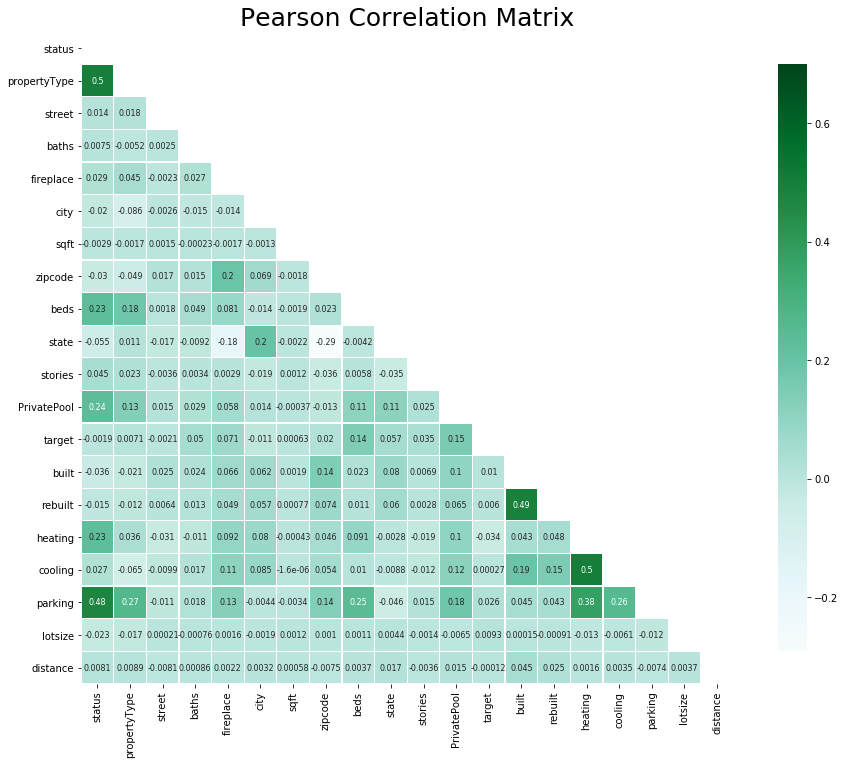

In [265]:
mask = np.zeros_like(data[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(data[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn",
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

In [266]:
data.describe(percentiles=[.01, .02, .03, .05, .1, .5, .9, .92, .94, .98, .99])

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,stories,PrivatePool,target,built,rebuilt,heating,cooling,parking,lotsize,distance
count,236708.000000,236708.000000,236708.000000,236708.000000,236708.000000,236708.000000,2.367080e+05,236708.000000,236708.000000,236708.000000,236708.000000,236708.000000,2.367080e+05,236708.000000,236708.000000,236708.000000,236708.000000,236708.000000,2.367080e+05,236708.000000
mean,97.355856,877.226355,104120.622979,2.635234,0.384343,817.652572,4.938856e+03,2023.169399,3.094154,0.936859,1.489561,0.116274,6.308320e+05,1976.454636,1980.108370,0.850123,0.806838,0.663953,1.637704e+04,1.079466
std,56.378936,164.317097,60090.215675,11.607657,0.486441,440.983062,9.386034e+05,1044.892333,2.260241,0.856899,3.460091,0.320554,1.637491e+06,34.303614,57.081108,0.356951,0.394780,0.472356,7.278628e+05,6.532286
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000
1%,4.000000,77.000000,1978.070000,1.000000,0.000000,50.070000,5.700000e+02,101.000000,1.000000,0.000000,0.000000,0.000000,2.400000e+04,1897.000000,1900.000000,0.000000,0.000000,0.000000,3.000000e+00,0.100000
2%,4.000000,286.000000,4064.140000,1.000000,0.000000,66.000000,7.070000e+02,164.000000,1.000000,0.000000,0.000000,0.000000,4.000000e+04,1900.000000,1905.000000,0.000000,0.000000,0.000000,6.000000e+00,0.100000
3%,4.000000,343.000000,6131.210000,1.000000,0.000000,71.000000,7.800000e+02,189.000000,1.000000,0.000000,0.000000,0.000000,5.500000e+04,1909.000000,1911.000000,0.000000,0.000000,0.000000,2.500000e+01,0.100000
5%,4.000000,461.000000,10308.350000,1.000000,0.000000,134.000000,8.850000e+02,285.000000,1.000000,0.000000,1.000000,0.000000,7.990000e+04,1916.000000,1920.000000,0.000000,0.000000,0.000000,2.700000e+01,0.140000
10%,4.000000,852.000000,20751.700000,1.000000,0.000000,261.000000,1.051000e+03,765.000000,1.000000,0.000000,1.000000,0.000000,1.272590e+05,1925.000000,1931.000000,0.000000,0.000000,0.000000,3.400000e+01,0.200000
50%,140.000000,958.000000,104379.500000,2.000000,0.000000,770.000000,1.943000e+03,1808.000000,3.000000,1.000000,1.000000,0.000000,3.389995e+05,1982.000000,1988.000000,1.000000,1.000000,1.000000,5.000000e+03,0.600000


In [267]:
data = data[data['street'] >= 4000]
data = data[data['city'] > 66]
data = data[data['zipcode'] > 160]
data = data[data['sqft'] < 7000]
data = data[data['baths'] <= 8]
data = data[data['beds'] <= 7]
data = data[data['stories'] <= 6]
data = data[data['target'] <= 3500000]
data = data[data['built'] < 2020]
data = data[data['rebuilt'] < 2020]
data = data[data['lotsize'] <= 40000]
data = data[data['distance'] < 7]
data = data[data['built'] >= 1900]
data = data[data['rebuilt'] >= 1900]
data = data[data['sqft'] >= 220]
data = data[data['lotsize'] >= 6]
data = data[data['target'] >= 40000]
data = data[data['beds'] >= 1]

In [268]:
train_fe = copy.deepcopy(data)
target_fe = train_fe['target']
del train_fe['target']
X = train_fe
z = target_fe
Xtrain, Xval, Ztrain, Zval = train_test_split(X, z, test_size=0.2, random_state=21)
train_set = lgb.Dataset(Xtrain, Ztrain, silent=False)
valid_set = lgb.Dataset(Xval, Zval, silent=False)
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,        
    }

modelL = lgb.train(params, train_set = train_set, num_boost_round=1000,
                   early_stopping_rounds=50,verbose_eval=100, valid_sets=valid_set)

Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 251243
[200]	valid_0's rmse: 232796
[300]	valid_0's rmse: 223626
[400]	valid_0's rmse: 218117
[500]	valid_0's rmse: 213821
[600]	valid_0's rmse: 210742
[700]	valid_0's rmse: 208182
[800]	valid_0's rmse: 206093
[900]	valid_0's rmse: 204219
[1000]	valid_0's rmse: 202567
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 202567


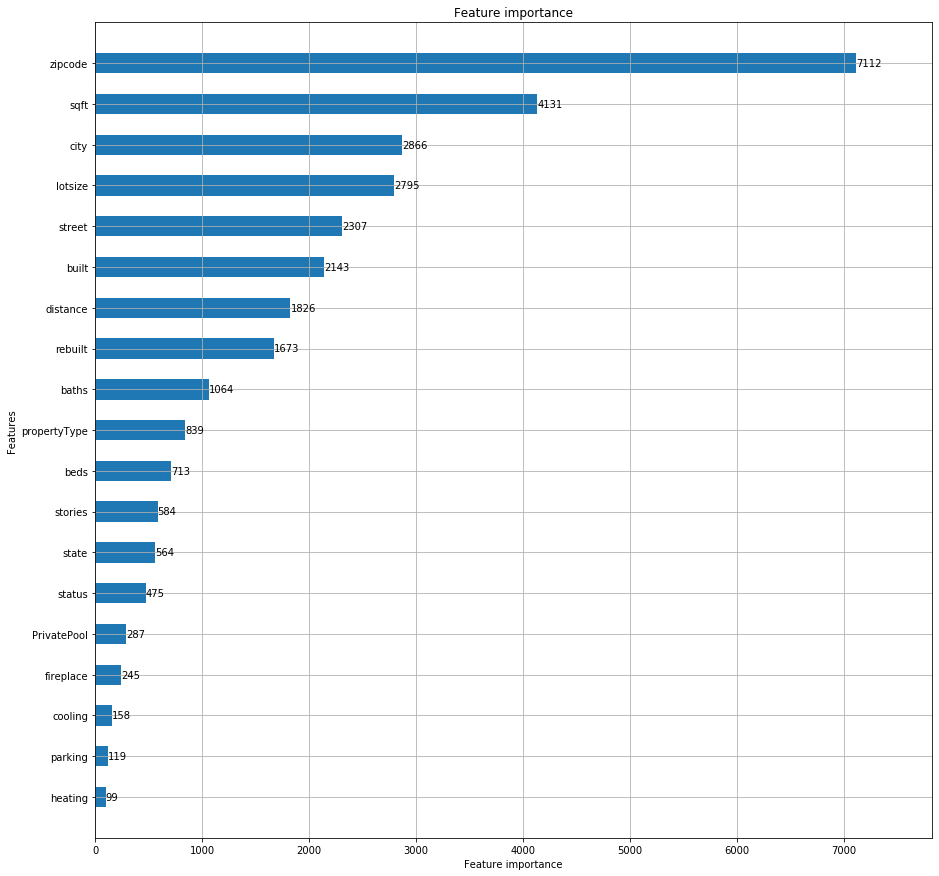

In [269]:
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
lgb.plot_importance(modelL,ax = axes,height = 0.5)
plt.show();plt.close()

In [270]:
feature_score = pd.DataFrame(train_fe.columns, columns = ['feature']) 
feature_score['score_lgb'] = modelL.feature_importance()

In [271]:
data_tr  = xgb.DMatrix(Xtrain, label=Ztrain)
data_cv  = xgb.DMatrix(Xval   , label=Zval)
evallist = [(data_tr, 'train'), (data_cv, 'valid')]
parms = {'max_depth':8, #maximum depth of a tree
         'objective':'reg:squarederror',
         'eta'      :0.3,
         'subsample':0.8,
         'lambda '  :4, 
         'colsample_bytree ':0.9,
         'colsample_bylevel':1,
         'min_child_weight': 10}
modelx = xgb.train(parms, data_tr, num_boost_round=200, evals = evallist,
                  early_stopping_rounds=30, maximize=False, 
                  verbose_eval=50)

print('score = %1.5f, n_boost_round =%d.'%(modelx.best_score,modelx.best_iteration))

[21:53:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colsample_bytree , lambda  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:505687.56250	valid-rmse:508153.18750
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:173920.23438	valid-rmse:212318.92188
[100]	train-rmse:153263.09375	valid-rmse:203258.76562
[150]	train-rmse:137712.45312	valid-rmse:198704.45312
[199]	train-rmse:126980.23438	valid-rmse:195502.78125
score = 195502.78125, n_boost_round =199.


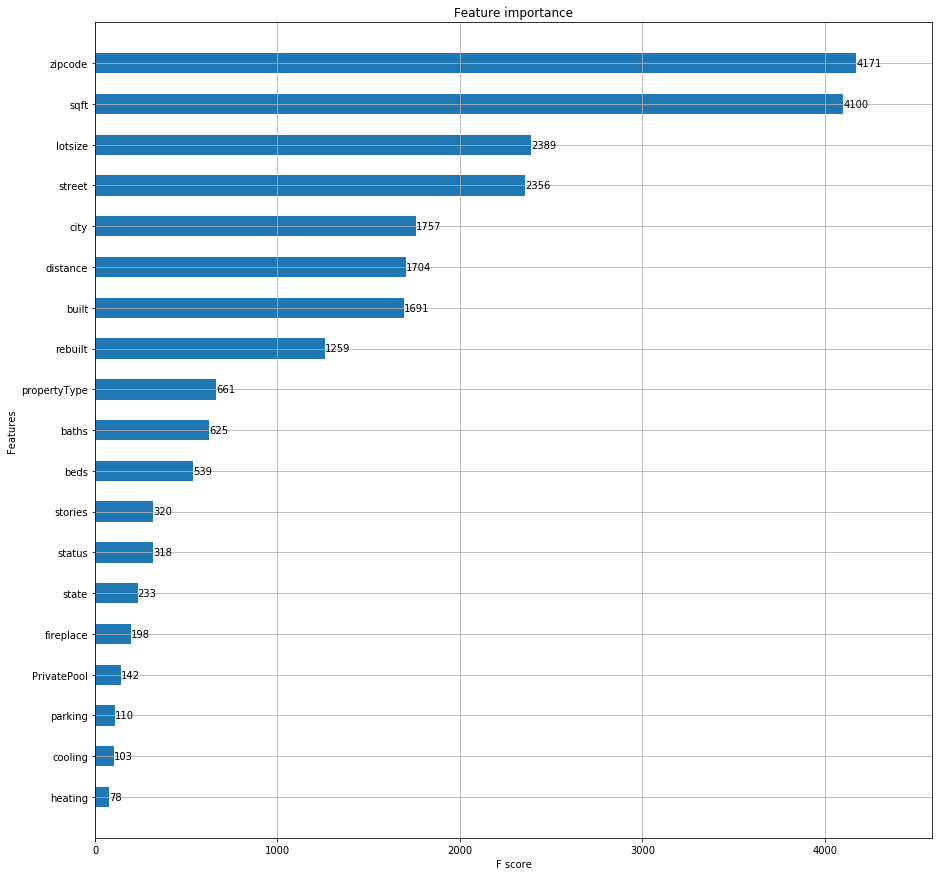

In [272]:
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
xgb.plot_importance(modelx,ax = axes,height = 0.5)
plt.show();plt.close()

In [273]:
feature_score['score_xgb'] = feature_score['feature'].map(modelx.get_score(importance_type='weight'))
feature_score

,feature,score_lgb,score_xgb
0,status,475,318
1,propertyType,839,661
2,street,2307,2356
3,baths,1064,625
4,fireplace,245,198
5,city,2866,1757
6,sqft,4131,4100
7,zipcode,7112,4171
8,beds,713,539
9,state,564,233


In [274]:
linreg = LinearRegression()
linreg.fit(train_fe, target_fe)
coeff_linreg = pd.DataFrame(train_fe.columns.delete(0))
coeff_linreg.columns = ['feature']
coeff_linreg["score_linreg"] = pd.Series(linreg.coef_)
coeff_linreg.sort_values(by='score_linreg', ascending=False)

,feature,score_linreg
3,fireplace,104381.656405
9,stories,104016.353652
11,built,84899.979107
16,lotsize,39522.446311
10,PrivatePool,9732.279086
6,zipcode,231.563199
7,beds,57.678575
2,baths,-0.078789
17,distance,-4.576116
5,sqft,-19.374223


In [275]:
coeff_linreg["score_linreg"] = coeff_linreg["score_linreg"].abs().astype(int)
feature_score = pd.merge(feature_score, coeff_linreg, on='feature')
feature_score = feature_score.fillna(0)
feature_score = feature_score.set_index('feature')
feature_score

,score_lgb,score_xgb,score_linreg
feature,,,
propertyType,839,661,178
street,2307,2356,51
baths,1064,625,0
fireplace,245,198,104381
city,2866,1757,19091
sqft,4131,4100,19
zipcode,7112,4171,231
beds,713,539,57
state,564,233,58173


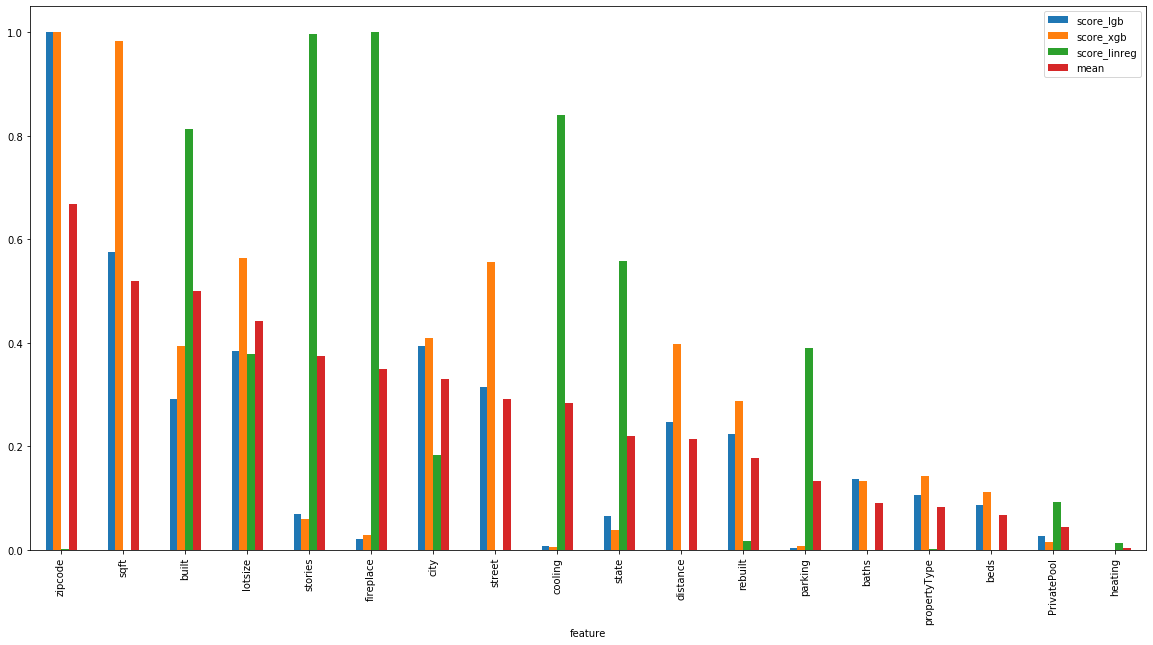

In [276]:
feature_score = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(feature_score),
    columns=feature_score.columns,
    index=feature_score.index
)

feature_score['mean'] = feature_score.mean(axis=1)

feature_score.sort_values('mean', ascending=False).plot(kind='bar', figsize=(20, 10))

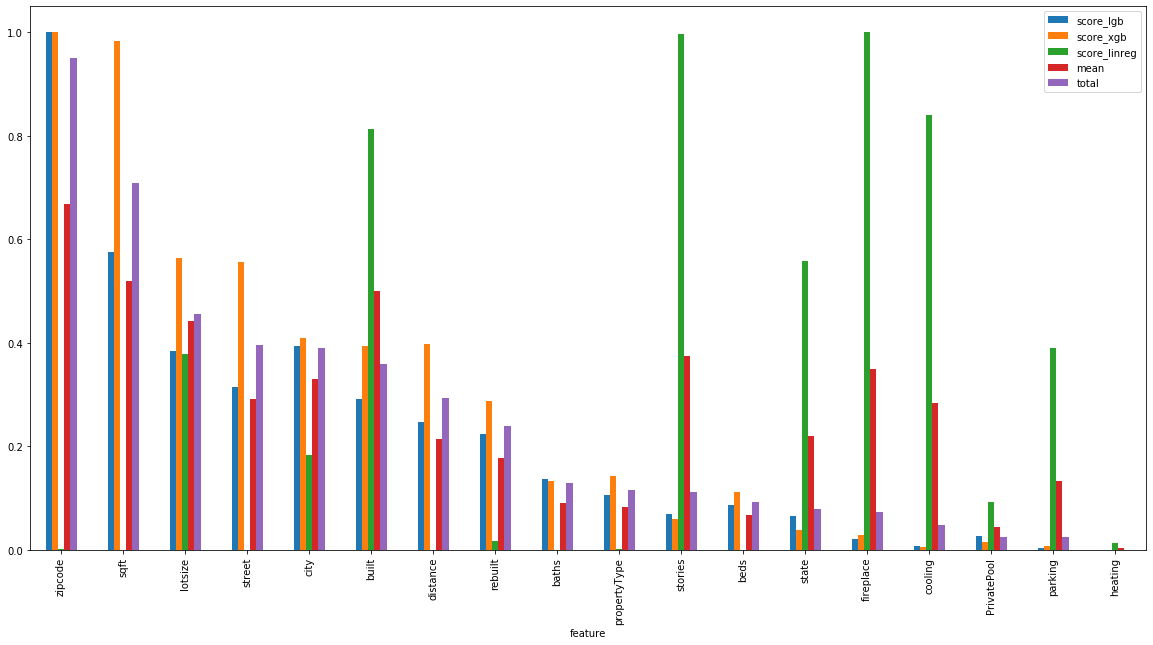

In [277]:
feature_score['total'] = 0.55*feature_score['score_lgb'] + 0.4*feature_score['score_xgb'] \
                       + 0.05*feature_score['score_linreg']

feature_score.sort_values('total', ascending=False).plot(kind='bar', figsize=(20, 10))

In [278]:
feature_score.sort_values('total', ascending=False)

,score_lgb,score_xgb,score_linreg,mean,total
feature,,,,,
zipcode,1.000000,1.000000,0.002213,0.667404,0.950111
sqft,0.574932,0.982653,0.000182,0.519256,0.709283
lotsize,0.384429,0.564623,0.378632,0.442561,0.456217
street,0.314844,0.556560,0.000489,0.290631,0.395813
city,0.394553,0.410213,0.182897,0.329221,0.390234
built,0.291459,0.394087,0.813357,0.499634,0.358605
distance,0.246257,0.397264,0.000038,0.214520,0.294349
rebuilt,0.224440,0.288541,0.017695,0.176892,0.239743
baths,0.137602,0.133643,0.000000,0.090415,0.129138


In [279]:
data = data.drop(['heating', 'parking', 'PrivatePool', 'cooling', 'fireplace', 'state'], axis = 1)

In [280]:
valid_part = 0.3
target_name = 'target'
train_target0 = data[target_name]
train0 = data.drop([target_name], axis=1)
train0, test0, train_target0, test_target0 = train_test_split(train0, train_target0, test_size=0.2, random_state=0)
train0b = train0
train_target0b = train_target0
trainb, testb, targetb, target_testb = train_test_split(train0b, train_target0b, test_size=valid_part, random_state=0)
train, test, target, target_test = train_test_split(train0, train_target0, test_size=valid_part, random_state=0)

In [281]:
acc_train_r2 = []
acc_test_r2 = []
acc_train_rmse = []
acc_test_rmse = []
acc_train_mape = []
acc_test_mape = []

def acc_d(y_meas, y_pred):
    return mean_absolute_error(y_meas, y_pred)*len(y_meas)/sum(abs(y_meas))

def acc_rmse(y_meas, y_pred):
    return (mean_squared_error(y_meas, y_pred))**0.5

def acc_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

def acc_boosting_model(num,model,train,test,num_iteration=0):
    global acc_train_r2, acc_test_r2, acc_train_rmse, acc_test_rmse, acc_train_mape, acc_test_mape
    if num_iteration > 0:
        ytrain = model.predict(train, num_iteration = num_iteration)  
        ytest = model.predict(test, num_iteration = num_iteration)
    else:
        ytrain = model.predict(train)  
        ytest = model.predict(test)

    print('target = ', targetb[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(targetb, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)
    
    acc_train_mape_num = round(acc_mape(targetb, ytrain) * 100, 2)
    print('acc(mape) for train =', acc_train_mape_num)   
    acc_train_mape.insert(num, acc_train_mape_num)

    acc_train_rmse_num = round(acc_rmse(targetb, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_testb[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_testb, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)

    acc_test_mape_num = round(acc_mape(target_testb, ytest) * 100, 2)
    print('acc(mape) for test =', acc_test_mape_num)   
    acc_test_mape.insert(num, acc_test_mape_num)
    
    acc_test_rmse_num = round(acc_rmse(target_testb, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

In [282]:
def acc_model(num,model,train,test):  
  
    global acc_train_r2, acc_test_r2, acc_train_rmse, acc_test_rmse, acc_train_mape, acc_test_mape
    
    ytrain = model.predict(train)  
    ytest = model.predict(test)

    print('target = ', target[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(target, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)
    
    acc_train_mape_num = round(acc_mape(target, ytrain) * 100, 2)
    print('acc(mape) for train =', acc_train_mape_num)   
    acc_train_mape.insert(num, acc_train_mape_num)

    acc_train_rmse_num = round(acc_rmse(target, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_test[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_test, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_mape_num = round(acc_mape(target_test, ytest) * 100, 2)
    print('acc(mape) for test =', acc_test_mape_num)
    acc_test_mape.insert(num, acc_test_mape_num)
    
    acc_test_rmse_num = round(acc_rmse(target_test, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

In [283]:
random_forest = RandomForestRegressor(n_estimators = 300, max_depth = 7, random_state = 21)
random_forest.fit(train, target)
acc_model(1,random_forest,train,test)

target =  [ 925000  569900 1398000  975000  144900]
ytrain =  [896290.97489953 622078.88202534 687080.75576481 435965.67298876
 188329.41896824]
acc(r2_score) for train = 63.61
acc(mape) for train = 47.39
acc(rmse) for train = 27980948.58
target_test = [519900 369990 439900 118750  70300]
ytest = [655652.41803352 282458.30369936 377582.68799433 191037.34766429
 214577.65184534]
acc(r2_score) for test = 61.7
acc(mape) for test = 47.73
acc(rmse) for test = 28536709.18


In [284]:
xgb_clf = xgb.XGBRegressor() 
parameters = {'n_estimators': [300], 
              'learning_rate': [0.1],
              'max_depth': [10],
              'reg_lambda': [0.5]}
xgb_reg = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1).fit(trainb, targetb)
print("Best score: %0.3f" % xgb_reg.best_score_)
print("Best parameters set:", xgb_reg.best_params_)
acc_boosting_model(2,xgb_reg,trainb,testb)

Best score: 0.811
Best parameters set: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300, 'reg_lambda': 0.5}
target =  [ 925000  569900 1398000  975000  144900]
ytrain =  [ 926353.4   570176.25 1205027.9   903195.    134223.31]
acc(r2_score) for train = 97.04
acc(mape) for train = 15.71
acc(rmse) for train = 7983087.19
target_test = [519900 369990 439900 118750  70300]
ytest = [679642.7  424354.62 405741.8  152435.25 126002.1 ]
acc(r2_score) for test = 82.81
acc(mape) for test = 24.2
acc(rmse) for test = 19117250.21


In [285]:
Xtrain, Xval, Ztrain, Zval = train_test_split(trainb, targetb, test_size=0.2, random_state=0)
train_set = lgb.Dataset(Xtrain, Ztrain, silent=False)
valid_set = lgb.Dataset(Xval, Zval, silent=False)

params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 100,
        'learning_rate': 0.1,
        'max_bin' : 3000 ,
        'colsample_bytree': 0.9,
        'metric': 'rmse',
        'min_child_samples': 9,
        'zero_as_missing': False,
        'seed':0,        
    }
modelL = lgb.train(params, train_set = train_set, num_boost_round=10000,
                   early_stopping_rounds=8000,verbose_eval=1000, valid_sets=valid_set)

Training until validation scores don't improve for 8000 rounds
[1000]	valid_0's rmse: 191245
[2000]	valid_0's rmse: 188865
[3000]	valid_0's rmse: 188270
[4000]	valid_0's rmse: 187951
[5000]	valid_0's rmse: 187845
[6000]	valid_0's rmse: 187751
[7000]	valid_0's rmse: 187688
[8000]	valid_0's rmse: 187656
[9000]	valid_0's rmse: 187642
[10000]	valid_0's rmse: 187633
Did not meet early stopping. Best iteration is:
[9931]	valid_0's rmse: 187633


In [286]:
acc_boosting_model(3,modelL,trainb,testb,modelL.best_iteration)

target =  [ 925000  569900 1398000  975000  144900]
ytrain =  [ 925351.23633742  570070.99641799 1396177.45755707  928031.13620875
  143774.67405407]
acc(r2_score) for train = 96.72
acc(mape) for train = 4.92
acc(rmse) for train = 8395104.36
target_test = [519900 369990 439900 118750  70300]
ytest = [488522.69857838 391108.76707682 431316.77227987 163235.5347511
 121050.32231106]
acc(r2_score) for test = 84.35
acc(mape) for test = 22.4
acc(rmse) for test = 18238378.22


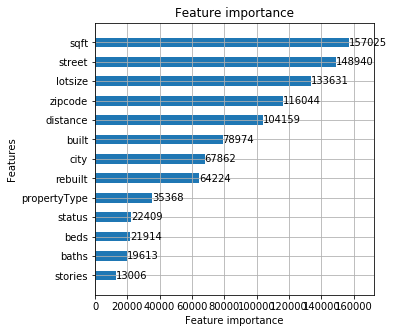

In [287]:
fig =  plt.figure(figsize = (5,5))
axes = fig.add_subplot(111)
lgb.plot_importance(modelL,ax = axes,height = 0.5)
plt.show();
plt.close()

In [288]:
models = pd.DataFrame({
    'Model': ['Random Forest', 'XGB', 'LGBM'],
    
    'r2_train': acc_train_r2,
    'r2_test': acc_test_r2,
    'mape_train': acc_train_mape,
    'mape_test': acc_test_mape,
    'rmse_train': acc_train_rmse,
    'rmse_test': acc_test_rmse
                     })

In [289]:
print('Prediction accuracy for models by different metrics')
models.sort_values(by=['mape_test', 'mape_train'], ascending=False)

Prediction accuracy for models by different metrics


,Model,r2_train,r2_test,mape_train,mape_test,rmse_train,rmse_test
0,Random Forest,63.61,61.70,47.39,47.73,27980948.58,28536709.18
1,XGB,97.04,82.81,15.71,24.20,7983087.19,19117250.21
2,LGBM,96.72,84.35,4.92,22.40,8395104.36,18238378.22


In [290]:
lgb_predict = modelL.predict(test0)

In [291]:
final_df = test_target0.values
final_df = pd.DataFrame(final_df,columns=['Real_price'])
for x in range(len(lgb_predict)):
    lgb_predict[x] = round(lgb_predict[x]/1000)*1000
final_df['predicted_prices'] = lgb_predict.astype(int)
final_df['difference'] = abs(final_df['Real_price'] - final_df['predicted_prices']).astype(int)
final_df.head(10)

,Real_price,predicted_prices,difference
0,110000,74000,36000
1,334750,314000,20750
2,269900,203000,66900
3,279000,484000,205000
4,279900,273000,6900
5,434900,453000,18100
6,199990,330000,130010
7,995000,656000,339000
8,585000,549000,36000
9,248500,236000,12500


In [292]:
import pickle
with open('mymodel.pkl', 'wb') as output:
       pickle.dump(modelL, output)